In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [2]:
train = train[['X{:02}'.format(i) for i in range(40) 
               if i not in (14, 16, 19)] + 
              ['Y{:02}'.format(i) for i in range(19)]]

In [3]:
temperature_name = ["X00","X07","X28","X31","X32"] #기온
localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
speed_name       = ["X02","X03","X18","X24","X26"] #풍속
water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
press_name       = ["X05","X08","X09","X23","X33"] #해면기압
sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량
humidity_name    = ["X12","X20","X30","X37","X38"] #습도
direction_name   = ["X13","X15","X17","X25","X35"] #풍향

In [4]:
pre_train_dataset = train[train['Y18'].isnull()][train.columns[:-1]]
fine_tuning_dataset = train[~train['Y18'].isnull()][
    list(train.columns[:37]) + [train.columns[-1]]]

#### pre-training
- char-CNN
- Multi-Lm (not bi-directional)

#### fine-tuning
- ELMo layer

- 단어 토큰의 숫자에는 우위가 없었다
- 그러나 이건 수치가 더 쎄냐 약하냐에 차이가 있다.

### 로스 함수나 조절해주는 Term을 바꿔주자

In [5]:
import torch
import torch.nn as nn

In [6]:
params = {
    'x': 'id', 
    'title': 'title',
    'figsize': (8, 3)
}

In [ ]:
params['y'] = temperature_name
pre_train_dataset.reset_index().plot(**params)

In [6]:
X = pre_train_dataset[['X{:02}'.format(i) for i in range(40) if i not in (14, 16, 19)]]

In [7]:
X

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,...,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,...,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,...,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,...,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,...,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,19.5,987.8,1.7,0.4,0.0,1007.8,988.0,21.3,1007.8,1007.5,...,82.3,18.8,19.4,1008.2,16.68,272.9,0.0,82.3,74.3,0.0
4316,19.3,987.7,2.1,0.9,0.0,1007.8,988.1,21.3,1008.0,1007.4,...,85.8,18.6,18.5,1008.4,16.68,315.9,0.0,82.4,74.8,0.0
4317,19.5,987.8,0.9,1.3,0.0,1007.8,988.3,21.2,1008.1,1007.5,...,84.1,18.4,19.1,1008.4,16.68,343.3,0.0,82.8,75.4,0.0


In [8]:
X = torch.Tensor(X.values)
X.shape

torch.Size([4320, 37])

1. AutoEncoder

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, num_features, c_num=2, emb_dim=256):
        super(AutoEncoder, self).__init__()
        self.num_features = num_features
        self.emb_dim = emb_dim
        
        self.encoder = nn.Linear(num_features, 2)
        self.decoder = nn.Linear(2, emb_dim)
    
    def forward(self, X):
        compressed_feature = self.encoder(X)
        generated_feature = self.decoder(compressed_feature)
        return generated_feature

In [10]:
X1 = X.view(4320, 37)
AE = AutoEncoder(37, c_num=12, emb_dim=256)
out1 = AE(X1)
out1.shape

torch.Size([4320, 256])

In [11]:
filters1d = [
    [16, 1],
    [16, 5],
    [32, 9],
    [64, 15],
    [128, 33],
    [256, 71],
]

class Conv1dMovingAverage(nn.Module):
    def __init__(self, num_features, filters):
        super(Conv1dMovingAverage, self).__init__()
        
        convolutions = []
        for i, (num_channels, num_kernel) in enumerate(filters, start=1):
            same_padding = num_kernel // 2
            conv = nn.Conv1d(
                in_channels=num_features,
                out_channels=num_channels,
                kernel_size=num_kernel,
                padding=same_padding
            )
            convolutions.append(conv)
        self.convolutions = nn.ModuleList(convolutions)
        self.activation = getattr(torch.nn.functional, 'relu')
        
    def forward(self, X):
        convs = []
        for i in range(len(self.convolutions)):
            convolved = self.convolutions[i](X)
            convolved = self.activation(convolved)
            convs.append(convolved)
        output = torch.cat(convs, dim=1)
        return output

In [31]:
a = torch.randn((5, 2))
print(a)
l = nn.Linear(2, 3)
print(l.weight)
l(a).

tensor([[-0.7708,  0.1286],
        [-2.6687, -2.3709],
        [-0.6448,  2.7428],
        [-0.2393, -0.3241],
        [ 0.3841, -1.4099]])
Parameter containing:
tensor([[-0.1239,  0.0766],
        [ 0.5373, -0.2404],
        [ 0.1121, -0.4433]], requires_grad=True)


tensor([[ 0.2484,  0.2435, -0.3025],
        [ 0.2921, -0.1756,  0.5928],
        [ 0.4330, -0.3172, -1.4473],
        [ 0.1479,  0.6379, -0.0423],
        [-0.0125,  1.2338,  0.5090]], grad_fn=<AddmmBackward>)

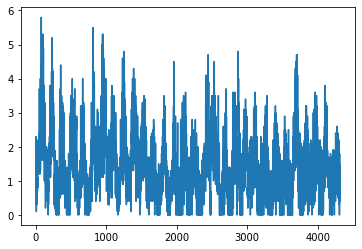

In [29]:
plt.plot(X1[:,3])

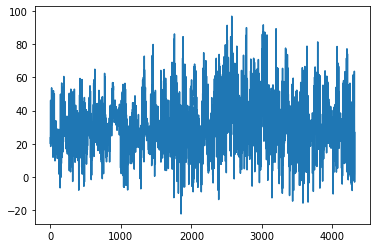

In [30]:
plt.plot(out1[:,3].detach().numpy())

In [12]:
X2 = X.view(1, 37, 4320)
CMA = Conv1dMovingAverage(37, filters1d)
out2 = CMA(X2)
out2 = out2.squeeze().view(4320, -1)
out2.shape

torch.Size([4320, 512])

In [13]:
class ConvolutionFeature(nn.Module):
    def __init__(self, num_features, emb_dim=256):
        super(ConvolutionFeature, self).__init__()
        self.num_features = num_features
        self.emb_dim = emb_dim
        
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=emb_dim, kernel_size=3, padding=1)
    
    def forward(self, X):
        c1 = self.conv1(X)
        c2 = self.conv2(c1)
        return c2

In [14]:
X3 = X.view(1, 37, 360, 12)
convfeat = ConvolutionFeature(37)
out3 = convfeat(X3)
out3 = out3.squeeze().view(4320, -1)
out3.shape

torch.Size([4320, 256])

In [15]:
out = torch.cat((out1, out2, out3), dim=-1)
out.shape

torch.Size([4320, 1024])

In [16]:
out

tensor([[  54.3661,  198.4838,  -14.0083,  ..., -149.4221, -446.3911,
         -154.4010],
        [  52.7208,  192.3011,  -13.5190,  ...,   55.1165, -196.3686,
          -54.1180],
        [  62.8106,  192.4989,   -2.9269,  ..., -331.6772,  -78.5236,
           57.5322],
        ...,
        [  15.0975,  181.8946,  -49.5304,  ..., -107.2757, -102.8517,
          291.3303],
        [   2.6992,  177.3641,  -61.0005,  ..., -149.0892,  145.8482,
         -307.1456],
        [ -17.9994,  159.7488,  -76.5275,  ...,   55.3896,  175.6889,
          -17.2077]], grad_fn=<CatBackward>)

In [50]:
out

tensor([[[ -79.7879,  189.1036, -195.0580,  ...,   20.0856,  257.8973,
             1.0869],
         [ -79.8797,  180.1695, -190.4928,  ...,  272.0146,  -80.8508,
           -60.3108],
         [ -79.2462,  183.4386, -191.4453,  ...,  254.5030,   54.0667,
           -24.8540],
         ...,
         [ -73.1949,  193.4825, -189.4589,  ...,  145.0238, -103.1906,
           199.4581],
         [ -71.3675,  196.6477, -188.9281,  ...,  191.3484,  216.2236,
           -61.9439],
         [ -71.4509,  197.1602, -189.2960,  ...,  182.9337,  205.9052,
           220.5890]],

        [[ -73.9337,  203.2333, -195.4455,  ...,  214.7716,   23.1575,
           -92.8764],
         [ -73.3262,  203.1035, -194.6506,  ...,  -83.6161,   77.5591,
            24.5661],
         [ -72.2375,  197.9994, -190.6766,  ..., -111.5578,  -76.2125,
            89.4946],
         ...,
         [ -74.5756,  178.9406, -183.5017,  ..., -214.1848, -199.8465,
          -195.4671],
         [ -79.9923,  170.2890, -185.457

In [112]:
out.view(SEQ_LEN, -1, 1024).shape

torch.Size([12, 360, 1024])

In [262]:
def fine_tune_generator(src, trg, seq_len, bsz=32, use_cuda=False):
    assert src.dim() == 3, "source shape is (seq_len, total_length, num_dim)"
    assert trg.dim() == 2, "target shape is (seq_len, total_length)"
    total_length = trg.shape[1]
    num_dim = src.shape[-1]
    src_, trg_ = [], []
    for i in range(total_length):
        src_.append(src[:,i,:])
        trg_.append(trg[:,i])
        if len(src_) == bsz and len(trg_) == bsz:
            outsrc = torch.cat(src_, dim=0).view(seq_len, bsz, num_dim)
            outtrg = torch.cat(trg_, dim=0).view(seq_len, bsz)
            if use_cuda:
                outsrc = outsrc.cuda()
                outtrg = outtrg.cuda()
            yield outsrc, outtrg                  
            src_, trg_ = [], []
    if src_ is not [] and trg_ is not []:
        num_need_pad_zero = bsz - len(src_)
        for i in range(num_need_pad_zero):
            src_.append(torch.zeros(seq_len, num_dim))
            trg_.append(torch.zeros(seq_len))
        outsrc = torch.cat(src_, dim=0).view(seq_len, bsz, num_dim)
        outtrg = torch.cat(trg_, dim=0).view(seq_len, bsz)
        if use_cuda:
            outsrc = outsrc.cuda()
            outtrg = outtrg.cuda()
        yield outsrc, outtrg  
        
def pre_train_generator(src, seq_len, bsz=32, use_cuda=False):
    assert src.dim() == 3, "source shape is (seq_len, total_length, num_dim)"
    total_length = src.shape[1]
    num_dim = src.shape[-1]
    src_ = []
    for i in range(total_length):
        src_.append(src[:,i,:])
        if len(src_) == bsz:
            outsrc = torch.cat(src_, dim=0).view(seq_len, bsz, num_dim)
            if use_cuda:
                outsrc = outsrc.cuda()
            yield outsrc
            src_ = []
    if src_ is not []:
        num_need_pad_zero = bsz - len(src_)
        for i in range(num_need_pad_zero):
            src_.append(torch.zeros(seq_len, num_dim))
        outsrc = torch.cat(src_, dim=0).view(seq_len, bsz, num_dim)
        if use_cuda:
            outsrc = outsrc.cuda()
        yield outsrc

In [263]:
src = out.view(12, 360, 1024)
trg = torch.Tensor(pre_train_dataset['Y01'].values).view(12, 360)

In [264]:
ftg = fine_tune_generator(src, trg, SEQ_LEN, BATCH_SIZE)
ptg = pre_train_generator(src, SEQ_LEN, BATCH_SIZE)

In [265]:
for x in ptg:
    print(x.shape)

torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])
torch.Size([12, 32, 1024])


In [266]:
for x, y in ftg:
    print(x.shape, y.shape)

torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])
torch.Size([12, 32, 1024]) torch.Size([12, 32])


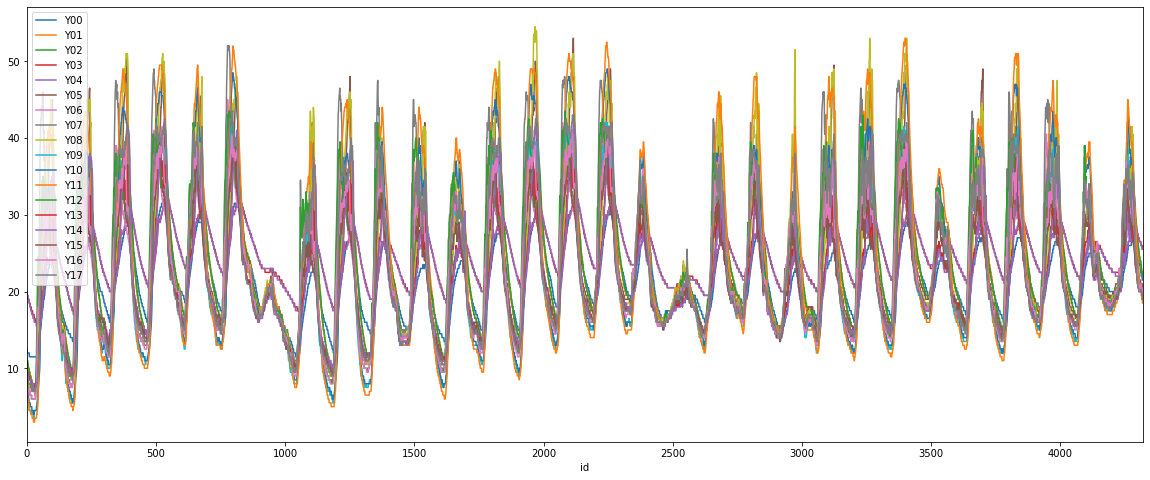

In [25]:
pre_train_dataset[['Y{:02}'.format(i) for i in range(18)]].plot(figsize=(20, 8))

# LSTM-based stacked autoencoder

In [212]:
import random

In [296]:
class Seq2CEncoder(nn.Module):
    def __init__(self, inp_dim, hid_dim, bsz=64, n_layers=1):
        super(Seq2CEncoder, self).__init__()
        h0 = torch.zeros(n_layers, bsz, hid_dim)
        c0 = torch.zeros(n_layers, bsz, hid_dim)
        nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
        self.h0 = nn.Parameter(h0, requires_grad=True)
        self.c0 = nn.Parameter(c0, requires_grad=True)
        self.LSTM = nn.LSTM(input_size=inp_dim,
                            hidden_size=hid_dim,
                            num_layers=n_layers)
    
    def forward(self, x):
        outputs, (hidden, cell) = self.LSTM(x)
        return hidden, cell
    
class C2SeqDecoder(nn.Module):
    def __init__(self, out_dim, hid_dim, bsz=64, n_layers=1):
        super(C2SeqDecoder, self).__init__()
        h0 = torch.zeros(n_layers, bsz, hid_dim)
        c0 = torch.zeros(n_layers, bsz, hid_dim)
        nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
        self.h0 = nn.Parameter(h0, requires_grad=True)
        self.c0 = nn.Parameter(c0, requires_grad=True)
        self.LSTM = nn.LSTM(input_size=out_dim,
                            hidden_size=hid_dim,
                            num_layers=n_layers)
        
    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.LSTM(x)
        return output, (hidden, cell)
    
class LSTM_AE(nn.Module):
    def __init__(self,
                 inp_dim,
                 out_dim,
                 hid_dim,
                 bsz=64,
                 n_layers=1,
                 use_cuda=False):
        super(LSTM_AE, self).__init__()
        self.bsz = bsz
        self.use_cuda = use_cuda
        self.output_dim = out_dim
        self.encoder = Seq2CEncoder(inp_dim, hid_dim, bsz, n_layers)
        self.decoder = C2SeqDecoder(out_dim, hid_dim, bsz, n_layers)
        if use_cuda:
            self.encoder = self.encoder.cuda()
            self.decoder = self.decoder.cuda()
    
    def forward(self, src):
        # 자기 표현 학습
        bsz = self.bsz
        seq_len = src.shape[0] # seq_len
        out_dim = self.output_dim
        
        outputs = torch.zeros(seq_len, bsz, out_dim)  
        if self.use_cuda:
            outputs = outputs.cuda()
        
        hidden, cell = self.encoder(src)
        
        # start first input
        input_ = src[0,:]
        for t in range(1, seq_len): # 1 to seq_len-1, except first input
            output, (hidden, cell) = self.decoder(input_, hidden, cell)
            outputs[t] = output
            input_ = src[t, :] # next input
        
        return outputs
    
class LSTM_SAE(nn.Module):
    """Pre-training model"""
    def __init__(self,
                 inp_dim,
                 out_dim,
                 hid_dim,
                 bsz=64,
                 n_layers=1,
                 use_cuda=False):
        super(LSTM_SAE, self).__init__()
        self.block1 = LSTM_AE(inp_dim, out_dim, hid_dim, bsz, n_layers, use_cuda)
        self.block2 = LSTM_AE(inp_dim, out_dim, hid_dim, bsz, n_layers, use_cuda)
        self.block3 = LSTM_AE(inp_dim, out_dim, hid_dim, bsz, n_layers, use_cuda)
        
class DLSTM(nn.Module):
    """Fine-tuning model"""
    def __init__(self):
        pass

In [297]:
INPUT_DIM = OUTPUT_DIM = 1024
HIDDEN_DIM = 64
BATCH_SIZE = 32
SEQ_LEN = 12
use_cuda = torch.cuda.is_available()

In [298]:
encoder = Seq2cEncoder(1024, 64, bsz=BATCH_SIZE)

In [299]:
block = LSTM_AE(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, BATCH_SIZE, use_cuda=use_cuda)

In [300]:
ptg = pre_train_generator(src, SEQ_LEN, BATCH_SIZE, use_cuda)

In [301]:
src1 = next(ptg)

In [305]:
src1[0,:].shape

torch.Size([32, 1024])

In [302]:
output1 = block(src1)

RuntimeError: input must have 3 dimensions, got 2

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [51]:
@torch.no_grad()
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [35]:
output.shape

torch.Size([1, 32, 64])